# Blocking Analysis

In [1]:
import numpy as np
import scipy as sp
import h5py 
import pandas as pd
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Test of dataset

In [2]:
file = f'blocking_info/CanESM2/blocking_info_canesm2_historical_rcp85_1_1980_2100_nh.mat'
matfile = h5py.File(file)
print(matfile.keys())

<KeysViewHDF5 ['AB_freq_Ac', 'AB_freq_TM', 'AB_info_Ac', 'AB_info_TM', 'UB_freq_Ac', 'UB_freq_TM', 'UB_info_Ac', 'UB_info_TM']>


## Read dataset

In [3]:
def read_B_info_1(B_info, ys, ye):
    """ read B_info
        return B[0, :] = year
               B[1, :] = number of events
               B[2, :] = mean duration
               B[3, :] = mean intensity
    """

    B = np.zeros((4, ye-ys+1))*np.nan
    for year in range(ys, ye+1):
        index = (B_info[0,:] == year)                                                # find the index for year
        B[0, year-ys] = year                                                         # year
        B[1, year-ys] = len(B_info[0,:][index])                                      # number of events
        if B[1, year-ys] > 0:
            B[2, year-ys] = np.mean(B_info[2,:][index] -B_info[1,:][index] +1)       # mean duration
            B[3, year-ys] = np.mean((B_info[2,:][index] -B_info[1,:][index] +1)  \
                                    *B_info[3,:][index]) / B[2, year-ys]             # mean intensity

    return B


def read_B_info_all(model_name='CanESM2', ensemble_size=50, var_name='UB_info_TM'):
    """ read B_info for all ensemble members
        return B[member, 0, :] = year
               B[member, 1, :] = number of events
               B[member, 2, :] = mean duration
               B[member, 3, :] = mean intensity
    """
    ys = 1980
    ye = 2100

    B = np.empty((0, 4, ye-ys+1))
    for member in range(1, ensemble_size+1):
        file = f'blocking_info/{model_name}/blocking_info_canesm2_historical_rcp85_{member}_{ys}_{ye}_nh.mat'
        matfile = h5py.File(file)
        #print(matfile.keys())
        B_info = matfile[var_name]
        B = np.vstack((B, read_B_info_1(B_info, ys, ye)[None, :, :]))

    return B

UB_TM = read_B_info_all(ensemble_size=50, var_name='UB_info_TM')
UB_Ac = read_B_info_all(ensemble_size=50, var_name='UB_info_Ac')
AB_TM = read_B_info_all(ensemble_size=50, var_name='AB_info_TM')
AB_Ac = read_B_info_all(ensemble_size=50, var_name='AB_info_Ac')


## Plotting the average number of blocks per winter

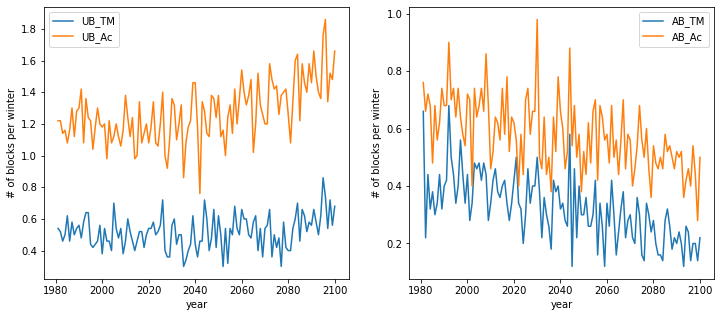

In [4]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
# skipping 1980 due to zero blocks
plt.plot(UB_TM[0, 0, 1:], np.mean(UB_TM[:, 1, 1:], axis=0), label='UB_TM')  # use regular mean
plt.plot(UB_Ac[0, 0, 1:], np.mean(UB_Ac[:, 1, 1:], axis=0), label='UB_Ac')
plt.xlabel('year')
plt.ylabel('# of blocks per winter')
plt.legend()

ax = fig.add_subplot(1,2,2)
# skipping 1980 due to zero blocks
plt.plot(AB_TM[0, 0, 1:], np.mean(AB_TM[:, 1, 1:], axis=0), label='AB_TM')  # use regular mean
plt.plot(AB_Ac[0, 0, 1:], np.mean(AB_Ac[:, 1, 1:], axis=0), label='AB_Ac')
plt.xlabel('year')
plt.ylabel('# of blocks per winter')
plt.legend()

## Plotting the average duration per block and duration at different percentiles

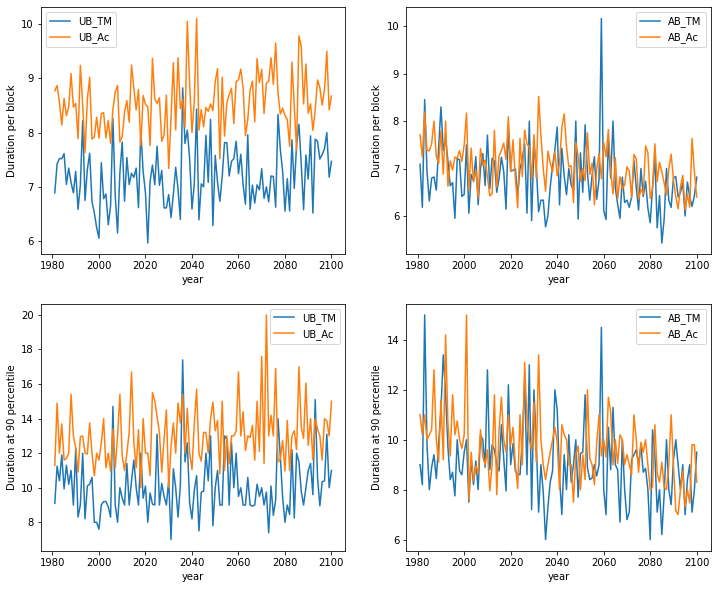

In [5]:
fig = plt.figure(figsize=(12,10))

# mean
ax = fig.add_subplot(2,2,1)
# skipping 1980 due to zero blocks
plt.plot(UB_TM[0, 0, 1:], np.nansum(UB_TM[:, 2, 1:]*UB_TM[:, 1, 1:], axis=0) \
                         /np.sum(UB_TM[:, 1, 1:], axis=0), label='UB_TM')  # use event-based nansum
plt.plot(UB_Ac[0, 0, 1:], np.nansum(UB_Ac[:, 2, 1:]*UB_Ac[:, 1, 1:], axis=0) \
                         /np.sum(UB_Ac[:, 1, 1:], axis=0), label='UB_Ac')  # use event-based nansum
plt.xlabel('year')
plt.ylabel('Duration per block')
plt.legend()

ax = fig.add_subplot(2,2,2)
# skipping 1980 due to zero blocks
plt.plot(AB_TM[0, 0, 1:], np.nansum(AB_TM[:, 2, 1:]*AB_TM[:, 1, 1:], axis=0) \
                         /np.sum(AB_TM[:, 1, 1:], axis=0), label='AB_TM')  # use event-based nansum
plt.plot(AB_Ac[0, 0, 1:], np.nansum(AB_Ac[:, 2, 1:]*AB_Ac[:, 1, 1:], axis=0) \
                         /np.sum(AB_Ac[:, 1, 1:], axis=0), label='AB_Ac')  # use event-based nansum
plt.xlabel('year')
plt.ylabel('Duration per block')
plt.legend()

# percentile
pctl_value=90

ax = fig.add_subplot(2,2,3)
# skipping 1980 due to zero blocks
plt.plot(UB_TM[0, 0, 1:], np.nanpercentile(UB_TM[:, 2, 1:], pctl_value, axis=0), \
                          label='UB_TM') 
plt.plot(UB_Ac[0, 0, 1:], np.nanpercentile(UB_Ac[:, 2, 1:], pctl_value, axis=0), \
                          label='UB_Ac')
plt.xlabel('year')
plt.ylabel(f'Duration at {pctl_value} percentile')
plt.legend()

ax = fig.add_subplot(2,2,4)
# skipping 1980 due to zero blocks
plt.plot(AB_TM[0, 0, 1:], np.nanpercentile(AB_TM[:, 2, 1:], pctl_value, axis=0), \
                          label='AB_TM') 
plt.plot(AB_Ac[0, 0, 1:], np.nanpercentile(AB_Ac[:, 2, 1:], pctl_value, axis=0), \
                          label='AB_Ac')
plt.xlabel('year')
plt.ylabel(f'Duration at {pctl_value} percentile')
plt.legend()


## Plotting average intensity per block and intensity at different percentiles
### Ac results are scaled by a factor 1/4 to compare with TM

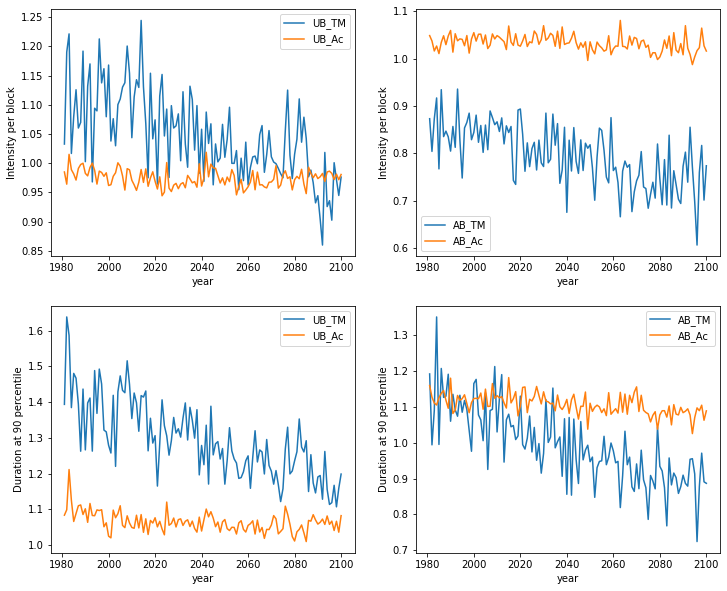

In [6]:

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(2,2,1)
# skipping 1980 due to zero blocks
plt.plot(UB_TM[0, 0, 1:], np.nansum(UB_TM[:, 3, 1:]*UB_TM[:, 2, 1:]*UB_TM[:, 1, 1:], axis=0) \
                         /np.nansum(UB_TM[:, 2, 1:]*UB_TM[:, 1, 1:], axis=0), label='UB_TM')  # use event-based nansum
plt.plot(UB_Ac[0, 0, 1:], np.nansum(UB_Ac[:, 3, 1:]*UB_Ac[:, 2, 1:]*UB_Ac[:, 1, 1:], axis=0) \
                         /np.nansum(UB_Ac[:, 2, 1:]*UB_Ac[:, 1, 1:], axis=0)/4, label='UB_Ac')  # use event-based nansum; scaled by a factor of 4
plt.xlabel('year')
plt.ylabel('Intensity per block')
plt.legend()

ax = fig.add_subplot(2,2,2)
# skipping 1980 due to zero blocks
plt.plot(AB_TM[0, 0, 1:], np.nansum(AB_TM[:, 3, 1:]*AB_TM[:, 2, 1:]*AB_TM[:, 1, 1:], axis=0) \
                         /np.nansum(AB_TM[:, 2, 1:]*AB_TM[:, 1, 1:], axis=0), label='AB_TM')  # use event-based nansum
plt.plot(AB_Ac[0, 0, 1:], np.nansum(AB_Ac[:, 3, 1:]*AB_Ac[:, 2, 1:]*AB_Ac[:, 1, 1:], axis=0) \
                         /np.nansum(AB_Ac[:, 2, 1:]*AB_Ac[:, 1, 1:], axis=0)/4, label='AB_Ac')  # use event-based nansum; scaled by a factor of 4
plt.xlabel('year')
plt.ylabel('Intensity per block')
plt.legend()

# percentile
pctl_value=90

ax = fig.add_subplot(2,2,3)
# skipping 1980 due to zero blocks
plt.plot(UB_TM[0, 0, 1:], np.nanpercentile(UB_TM[:, 3, 1:], pctl_value, axis=0), \
                          label='UB_TM') 
plt.plot(UB_Ac[0, 0, 1:], np.nanpercentile(UB_Ac[:, 3, 1:], pctl_value, axis=0)/4, \
                          label='UB_Ac')
plt.xlabel('year')
plt.ylabel(f'Duration at {pctl_value} percentile')
plt.legend()

ax = fig.add_subplot(2,2,4)
# skipping 1980 due to zero blocks
plt.plot(AB_TM[0, 0, 1:], np.nanpercentile(AB_TM[:, 3, 1:], pctl_value, axis=0), \
                          label='AB_TM') 
plt.plot(AB_Ac[0, 0, 1:], np.nanpercentile(AB_Ac[:, 3, 1:], pctl_value, axis=0)/4, \
                          label='AB_Ac')
plt.xlabel('year')
plt.ylabel(f'Duration at {pctl_value} percentile')
plt.legend()